In [413]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

from IPython.display import display_html
def display_side_by_side(*args):
    """
    Taken from https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

In [414]:
def plot_model_error(y, pred, figsize=(21, 10)):
    index = y.index
    
    y = np.asarray(y).ravel()
    pred = np.asarray(pred).ravel()
    error = pred - y
    mean_error = (np.abs(error)).mean() # mean_absolute_error(y, pred) 
    
    y = pd.Series(y, index=index)
    pred = pd.Series(pred, index=index)
    error = pd.Series(error, index=index)
        
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=figsize)
    
    y.plot(color="green", label="Ground truth", ax=axes[0])
    pred.plot(color="blue", alpha=0.6, label="Prediction", ax=axes[0])
    error.plot(color="red", label="Error", ax=axes[1])
    
    axes[1].axhline(0, 0, 1, color="black", linestyle="--")    
    axes[0].tick_params(axis='both', which='major', labelsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=14)

    axes[0].legend()
    axes[1].legend()
    fig.suptitle("Mean error: {:.5f}".format(mean_error), fontsize=20)
    fig.tight_layout();

def plot_cusum(y, pred, title=None, figsize=(21, 4), ax=None, **kwargs):
    
    index = y.index
    
    error = np.asarray(pred.ravel()) - np.asarray(y.ravel())         
    error = pd.Series(error, index=index)
    cumsum = pd.Series(data=np.cumsum(error), name="CUSUM", index=index)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)    
    fig = ax.figure
    
    cumsum.plot(ax=ax, color="red")
    ax.axhline(0, 0, 1, color="black", linestyle="--")
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    if title is not None:
        ax.set_title(title, fontsize=20)
    ax.legend()
    fig.tight_layout()

def plot_outputs(df, figsize=(18, 18)):    
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=figsize)
    
    total = df.ch1kw + df.ch2kw + df.ch3kw
    max_output = total.max()
    for i, ax in enumerate(axes[:3], 1): # in range(3):
        df["ch{}kw".format(i)].plot(ax=ax, title="ch{}kw".format(i))
        (df["ch{}_status".format(i)] * max_output).plot(ax=ax, alpha=0.3)

    total.plot(ax=axes[3], title="Total")
    fig.tight_layout()

In [415]:
df1 = pd.read_csv("../data/insead_2016_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")
df2 = pd.read_csv("../data/insead_2018_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")

In [416]:
features = [
"chwshdr",
"cwrhdr",
"cwshdr",
"cwsfhdr",
"loadsys",
"chwsfhdr", 

"ch1_status",
"ch2_status",
"ch3_status",
]

status_features = [
"ch1_status",
"ch2_status",
"ch3_status"    
]

target = ["totalkw"]

y1 = df1.totalkw
y2 = df2.totalkw
X1 = df1[features]
X2 = df2[features]

## Group data by days

In [417]:
assert X1.index.is_monotonic and X2.index.is_monotonic

In [418]:
group_days_2006 = X1.groupby(X1.index.dayofyear)
group_days_2008 = X2.groupby(X2.index.dayofyear)

y1_days_2006 = list(y1.groupby(y1.index.dayofyear))
y2_days_2008 = list(y2.groupby(y2.index.dayofyear))

assert(len(y1_days_2006) == len(group_days_2006)) and len(y2_days_2008) == len(group_days_2008)

keys_2006 = list(group_days_2006.groups.keys())
keys_2008 = list(group_days_2008.groups.keys())

# Data for days
d1_2006 = group_days_2006.get_group(keys_2006[0])
d2_2006 = group_days_2006.get_group(keys_2006[1])
d3_2006 = group_days_2006.get_group(keys_2006[20])

d1_2008 = group_days_2008.get_group(keys_2008[0])
d2_2008 = group_days_2008.get_group(keys_2008[1])
d3_2008 = group_days_2008.get_group(keys_2008[20])

days_2006 = list(group_days_2006)
days_2008 = list(group_days_2008)

print("Number of days for 2006 data: {}. Note some days might not have data.".format(len(group_days_2006)))
print("Number of days for 2008 data: {}. Note some days might not have data.".format(len(group_days_2008)))

Number of days for 2006 data: 58. Note some days might not have data.
Number of days for 2008 data: 37. Note some days might not have data.


## Train models

### Linear regression

Best param: [99859.82134647]


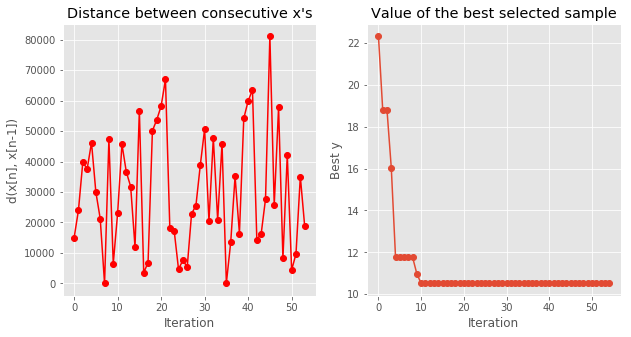

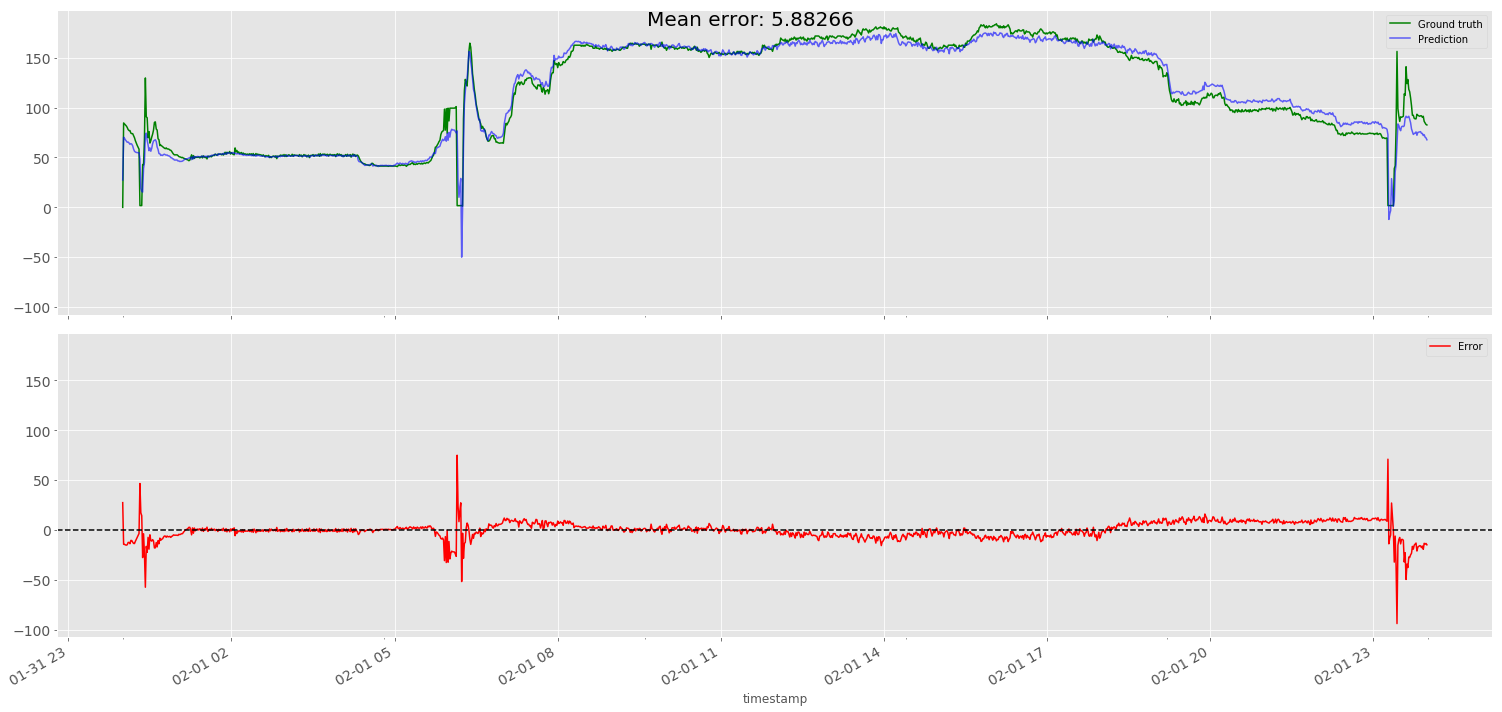

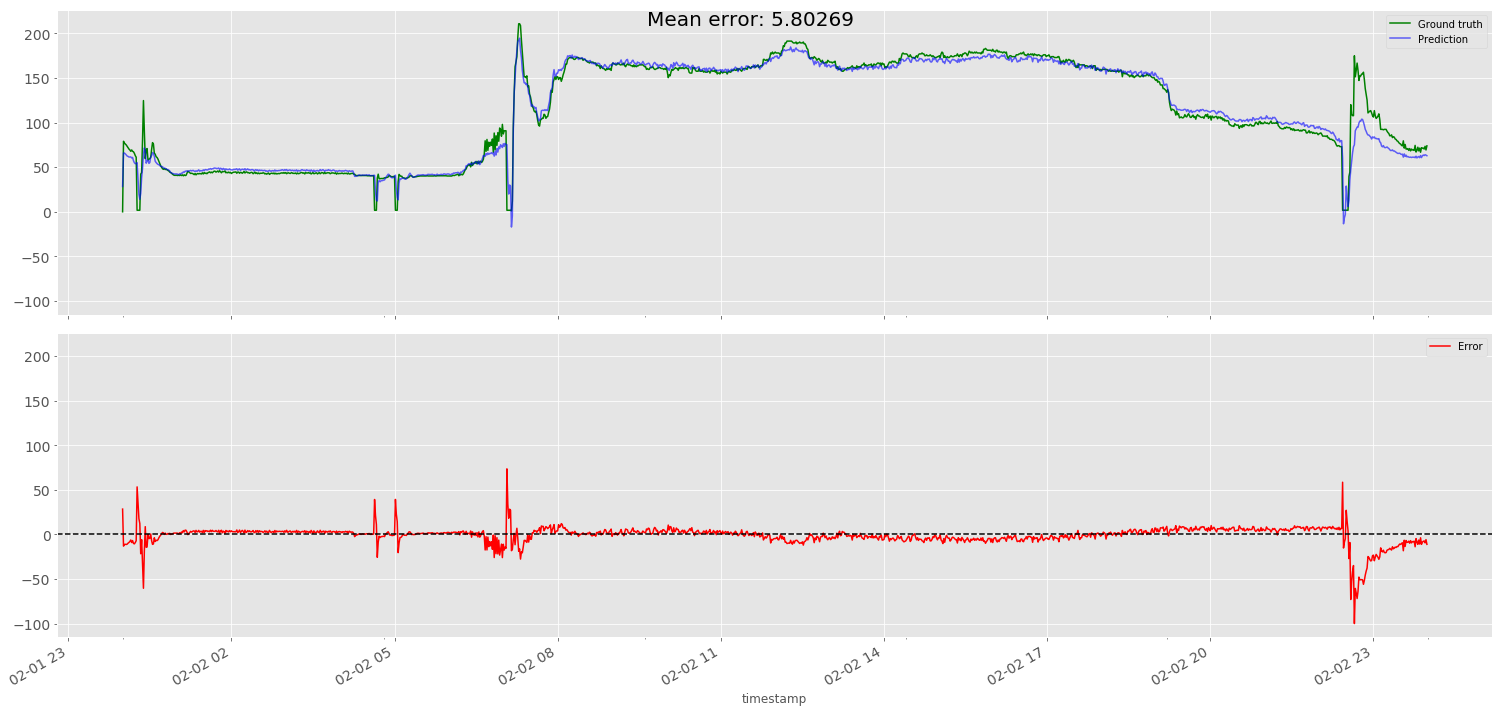

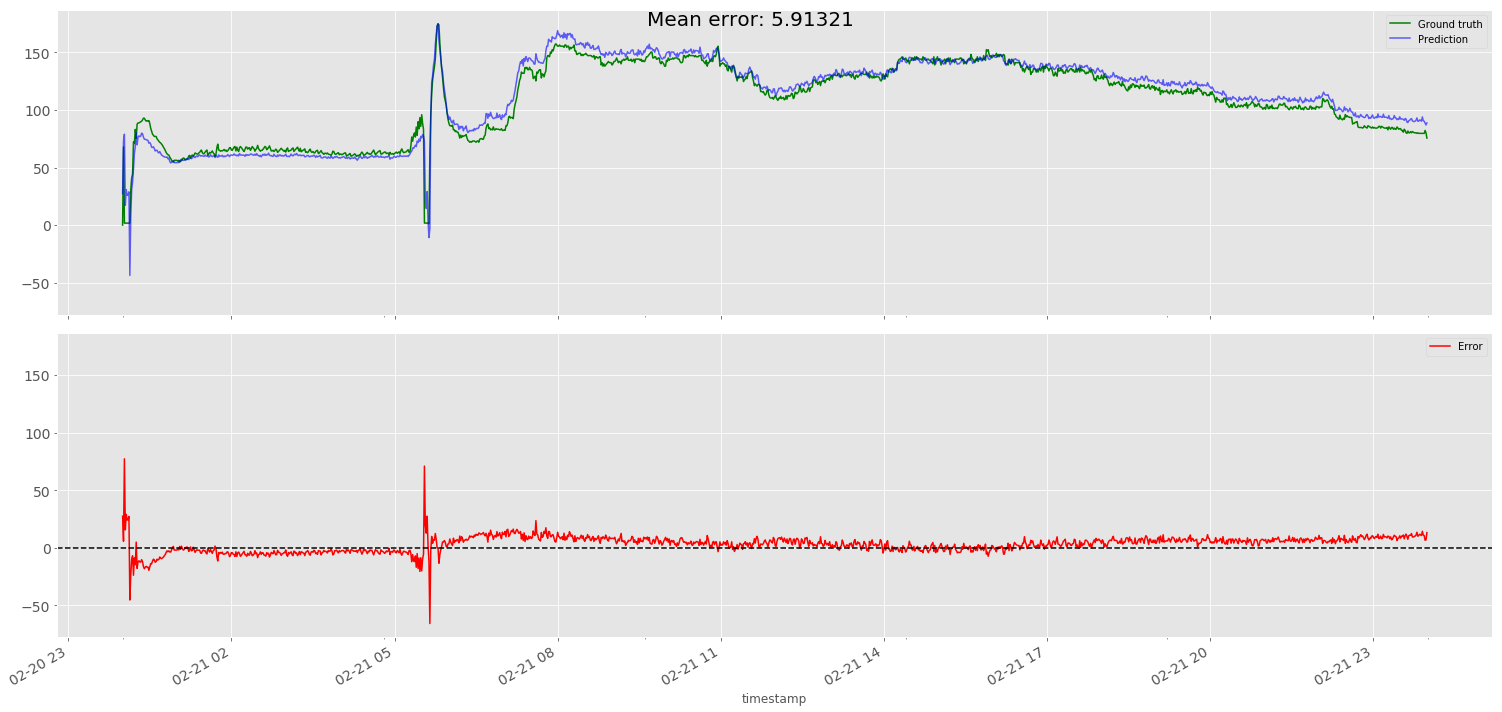

In [419]:
import GPyOpt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

N_TIMESERIES_SPLITS = 5
BO_RAND_STATE = 777
SCORE_TYPE = "neg_mean_absolute_error"

# Set up Bayesian Optimization
import functools

def f_lr(params, X, y, cv):
    params = params[0]
    score = -cross_val_score(Ridge(alpha=params[0]),                              
                             X, y,
                             cv=cv,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)

X1_train, y1_train = d1_2006.values, y1_days_2006[0][1].values

np.random.seed(BO_RAND_STATE)
f = functools.partial(f_lr, X=X1_train, y=y1_train, cv=TimeSeriesSplit(n_splits=3))
lr_domains = [{'name': 'alpha', 'type': 'continuous', 'domain': (1e-3, 1e5)}]
optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=lr_domains,
                                                acquisition_type='EI', # "LCB" works better
                                                acquisition_par=0.2,
                                                exact_feval=False)
optimizer.run_optimization(max_iter=50)
print("Best param: {}".format(optimizer.x_opt))

optimizer.plot_convergence()
# optimizer.plot_acquisition()

lr = Ridge(alpha=optimizer.x_opt[0])
lr.fit(X1_train, y1_train)

y1_pred = lr.predict(d1_2006.values)
y2_pred = lr.predict(d2_2006.values)
y3_pred = lr.predict(d3_2006.values)

plot_model_error(y1_days_2006[0][1], y1_pred)
plot_model_error(y1_days_2006[1][1], y2_pred)
plot_model_error(y1_days_2006[20][1], y3_pred)

In [420]:
y1_pred.shape

(1438,)

### Bayesian Optimization for selecting GP hyperparameters

In [421]:
from sklearn.base import BaseEstimator, ClassifierMixin

class GpyRegressor(BaseEstimator, ClassifierMixin):
    
    def __init__(self, lengthscale=1, variance=1):
        self.lengthscale = lengthscale
        self.variance = variance
                
    def fit(self, X, y):
        
        assert X.shape[0] == len(y), "Number of training examples and labels must match."
        
        dim = X.shape[1]
        self.input_dim_ = dim
        self.kernel_ = Matern32(dim, self.lengthscale, self.variance)
        self.regressor_ = GPRegression(X=X, Y=y.reshape(-1, 1), kernel=self.kernel_) 
        
        return self
    
    def predict(self, X, y=None):
        
        y_pred, _ = self.regressor_.predict(X)
        return y_pred

In [409]:
del k_m1
del k_m2
del k_m3

del K
del K11
del K12
del K13
del K1star
del K2
del K22
del K2star
del SparseGPRegression
del X1
del X2
del X_test

The set cost function is ignored! LCB acquisition does not make sense with cost.
Best param: [143.67571973 988.25393986]


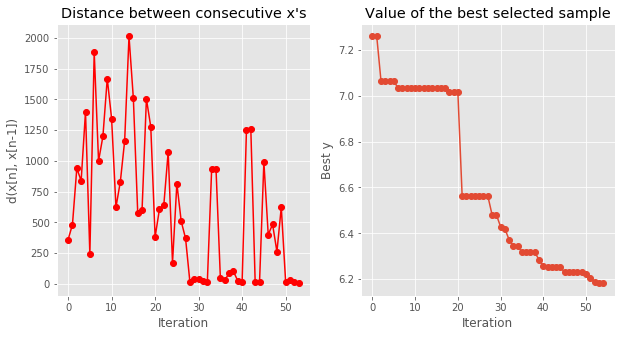

In [422]:
def f_gp(params, X, y, cv):
    params = params[0]
    lengthscale = params[0]
    variance = params[1]
            
    score = -cross_val_score(GpyRegressor(lengthscale, variance),                              
                             X, y,
                             cv=cv,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)




X1_train, y1_train = d1_2006.values, y1_days_2006[0][1].values.reshape(-1, 1)

np.random.seed(BO_RAND_STATE)
f = functools.partial(f_gp, X=X1_train, y=y1_train, cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS))
gp_domains = [{'name': 'lengthscale', 'type': 'continuous', 'domain': (1, 2e3)},
              {'name': 'variance', 'type': 'continuous', 'domain': (1, 1e3)}
             ]
optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=gp_domains,
                                                acquisition_type='LCB', # "LCB"
                                                acquisition_par=0.1,
                                                exact_feval=False)
optimizer.run_optimization(max_iter=50)
print("Best param: {}".format(optimizer.x_opt))

optimizer.plot_convergence()


In [424]:
optimizer.x_opt

array([143.67571973, 988.25393986])

In [425]:
lengthscale, variance = optimizer.x_opt

### GP model

In [294]:
from GPy.models import GPRegression, SparseGPRegression
from GPy.kern import Matern32, Matern52

In [426]:
dim = d1_2006.shape[1]

# lengthscale = 200
# variance = 20

k_matern32 = Matern32(input_dim=dim, lengthscale=lengthscale, variance=variance)
k_matern52 = Matern52(input_dim=dim, lengthscale=lengthscale, variance=variance)

k_m1 = Matern32(input_dim=dim, lengthscale=lengthscale, variance=variance)
k_m2 = Matern32(input_dim=dim, lengthscale=lengthscale, variance=variance)
k_m3 = Matern32(input_dim=dim, lengthscale=lengthscale, variance=variance)

gpr1 = GPRegression(X=d1_2006.values, Y=y1_days_2006[0][1].values.reshape(-1, 1), 
                    kernel=k_m1)
gpr2 = GPRegression(X=d2_2006.values, Y=y1_days_2006[1][1].values.reshape(-1, 1), 
                    kernel=k_m2)
gpr3 = GPRegression(X=d3_2006.values, Y=y1_days_2006[20][1].values.reshape(-1, 1), 
                    kernel=k_m3)

In [363]:
gpr1.optimize()
gpr1.kern

Mat32.,value,constraints,priors
variance,851.4522898126384,+ve,
lengthscale,61.07397021976118,+ve,


In [364]:
gpr2.optimize()
gpr2.kern

Mat32.,value,constraints,priors
variance,6985.048732334851,+ve,
lengthscale,109.33866209262042,+ve,


In [365]:
gpr3.optimize()
gpr3.kern

Mat32.,value,constraints,priors
variance,161345.03615402986,+ve,
lengthscale,661.2078048497552,+ve,


In [146]:
gpr1.optimize()
gpr2.optimize()
gpr3.optimize()

 /home/hongwei/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [167]:
display(gpr1.kern) 
display(gpr2.kern)
display(gpr3.kern)

Mat32.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1000.0,+ve,


Mat32.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1000.0,+ve,


Mat32.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1000.0,+ve,


## Test models

In [427]:
y1_pred, _ = gpr1.predict(d1_2006.values)
y2_pred, _ = gpr2.predict(d2_2006.values)
y3_pred, _ = gpr3.predict(d3_2006.values)

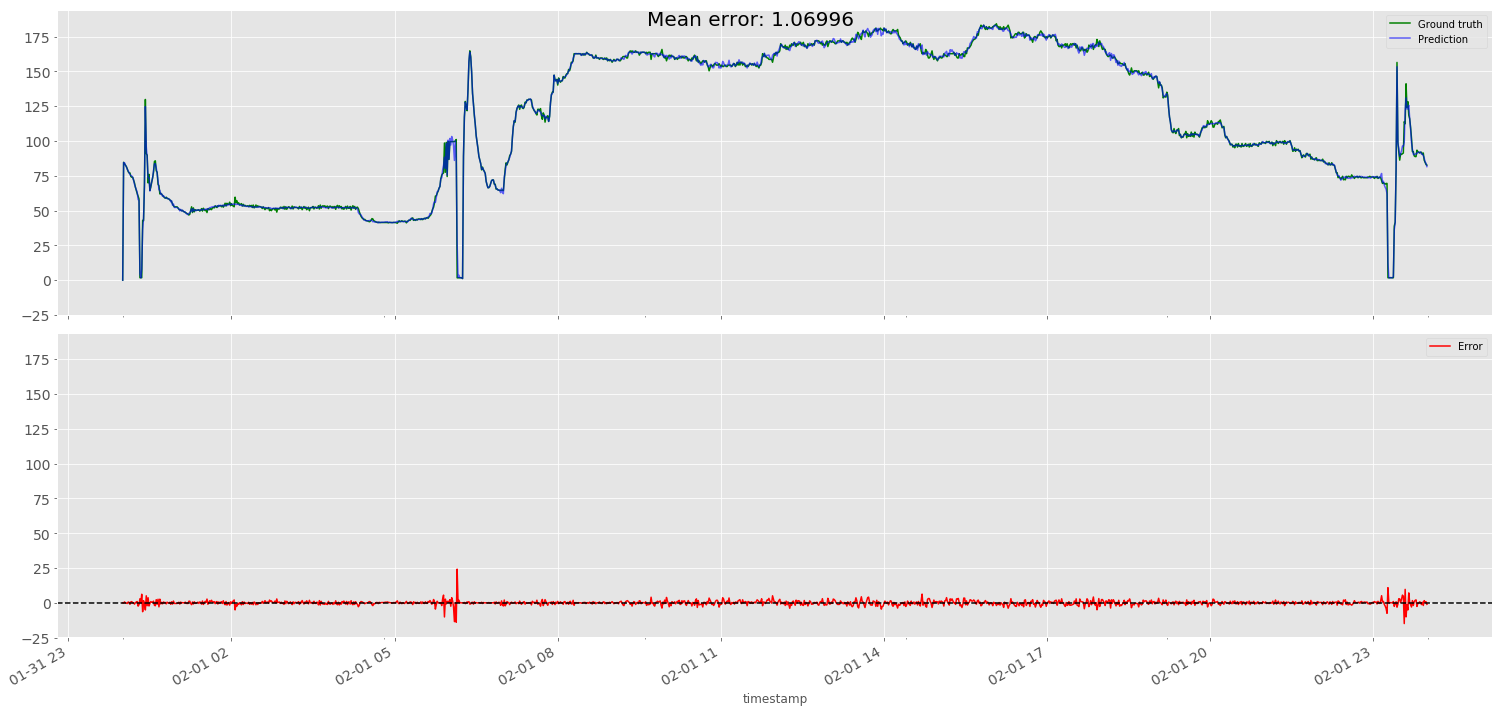

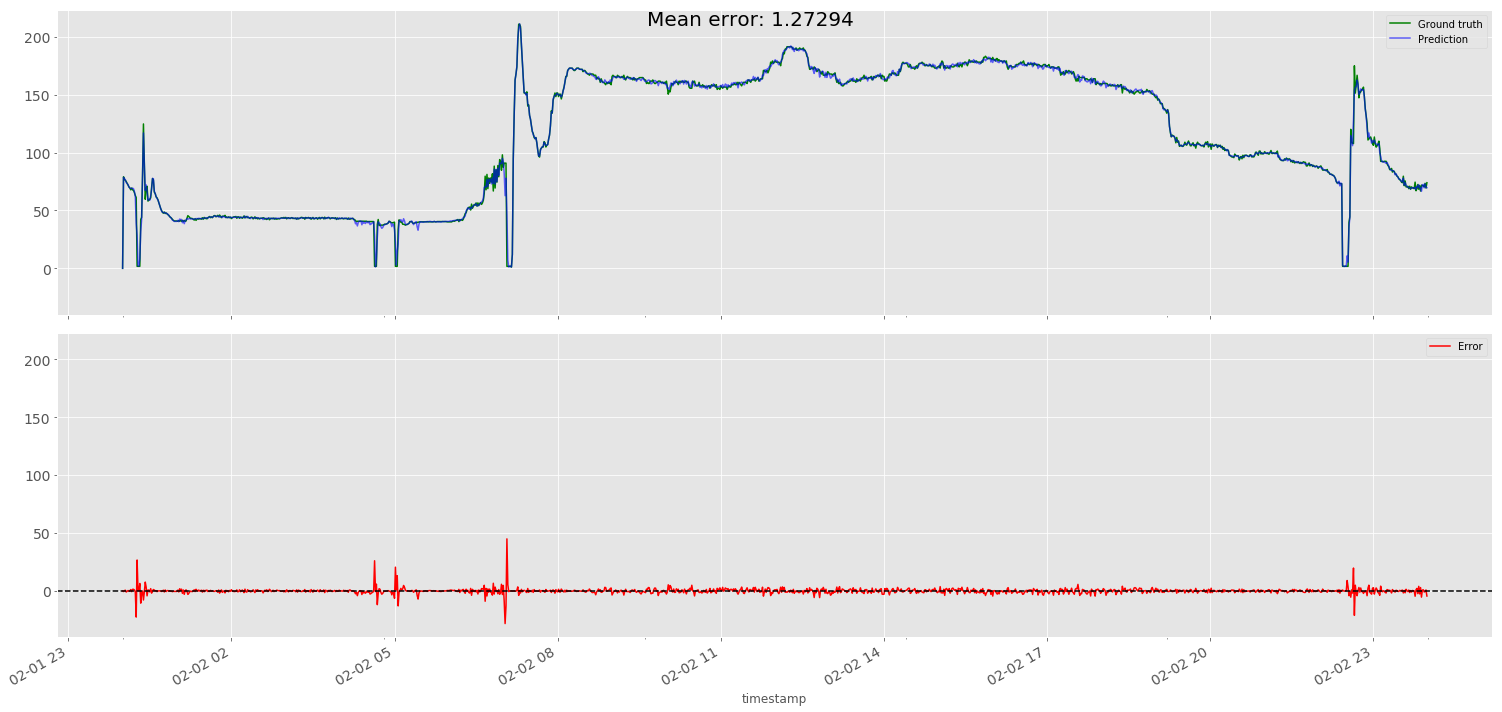

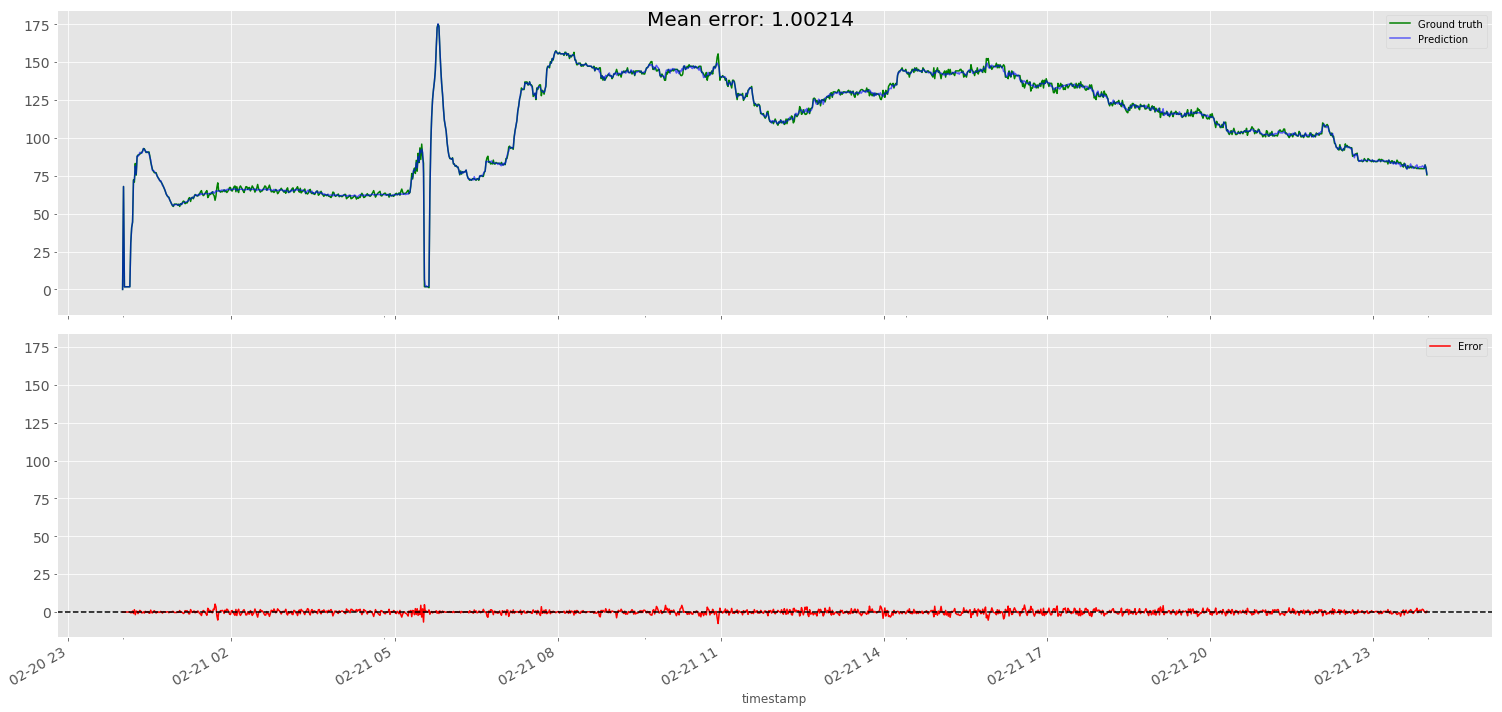

In [428]:
plot_model_error(y1_days_2006[0][1], y1_pred)
plot_model_error(y1_days_2006[1][1], y2_pred)
plot_model_error(y1_days_2006[20][1], y3_pred)

## Test models in different days in same year

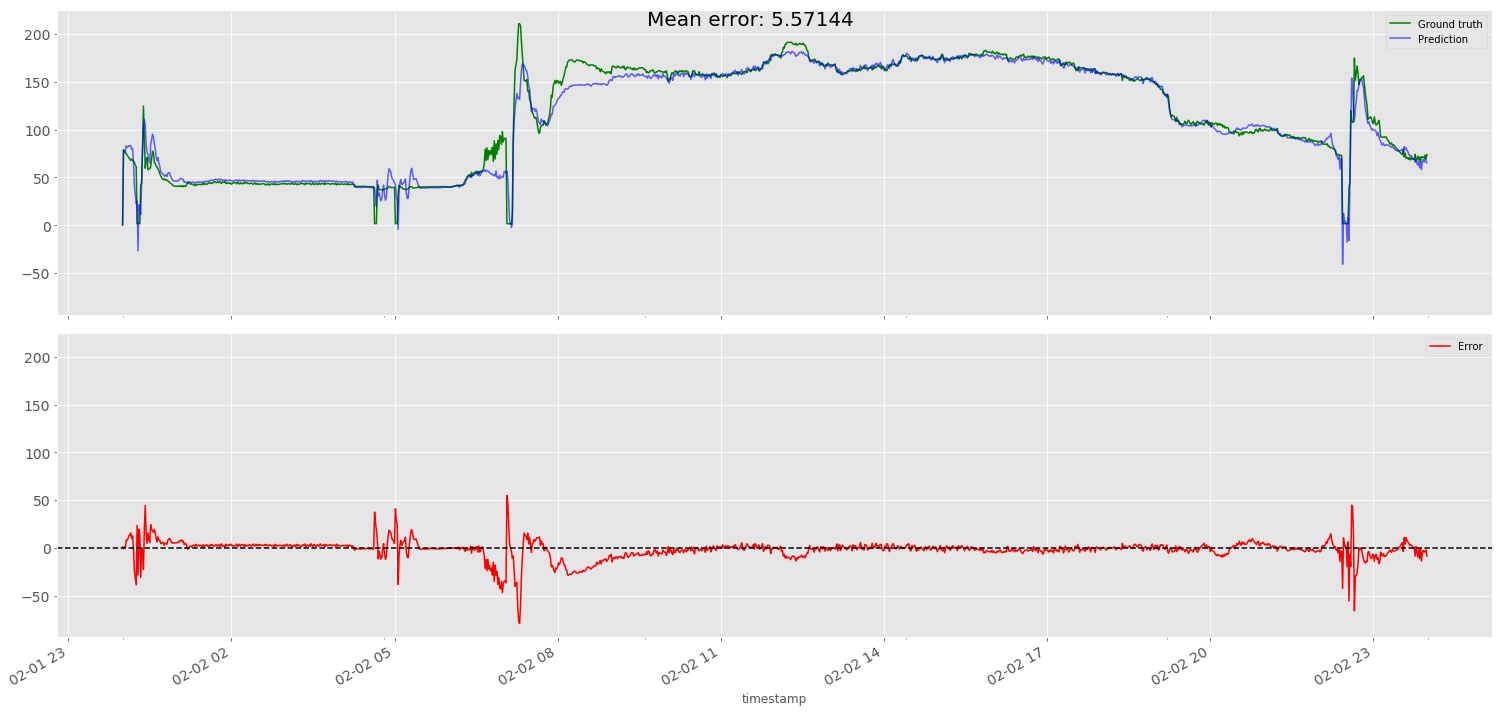

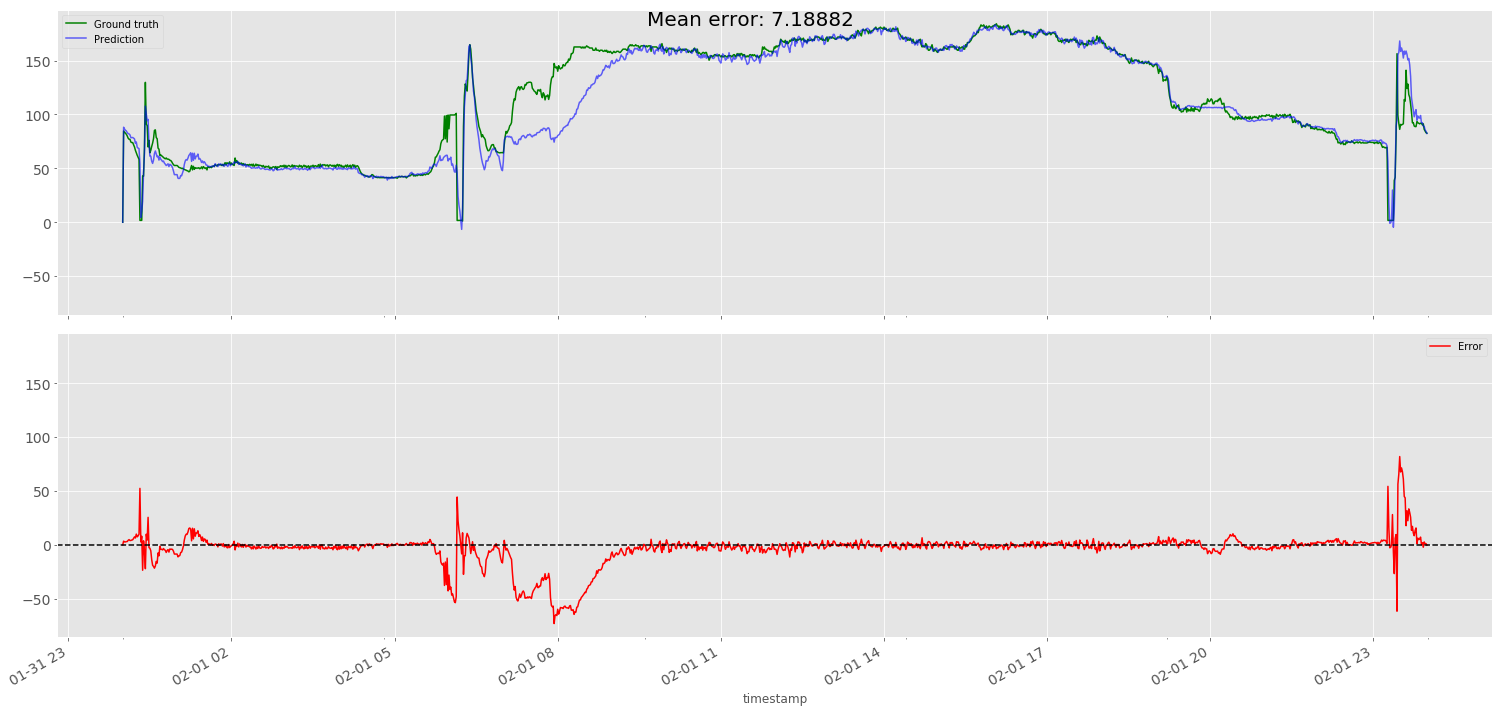

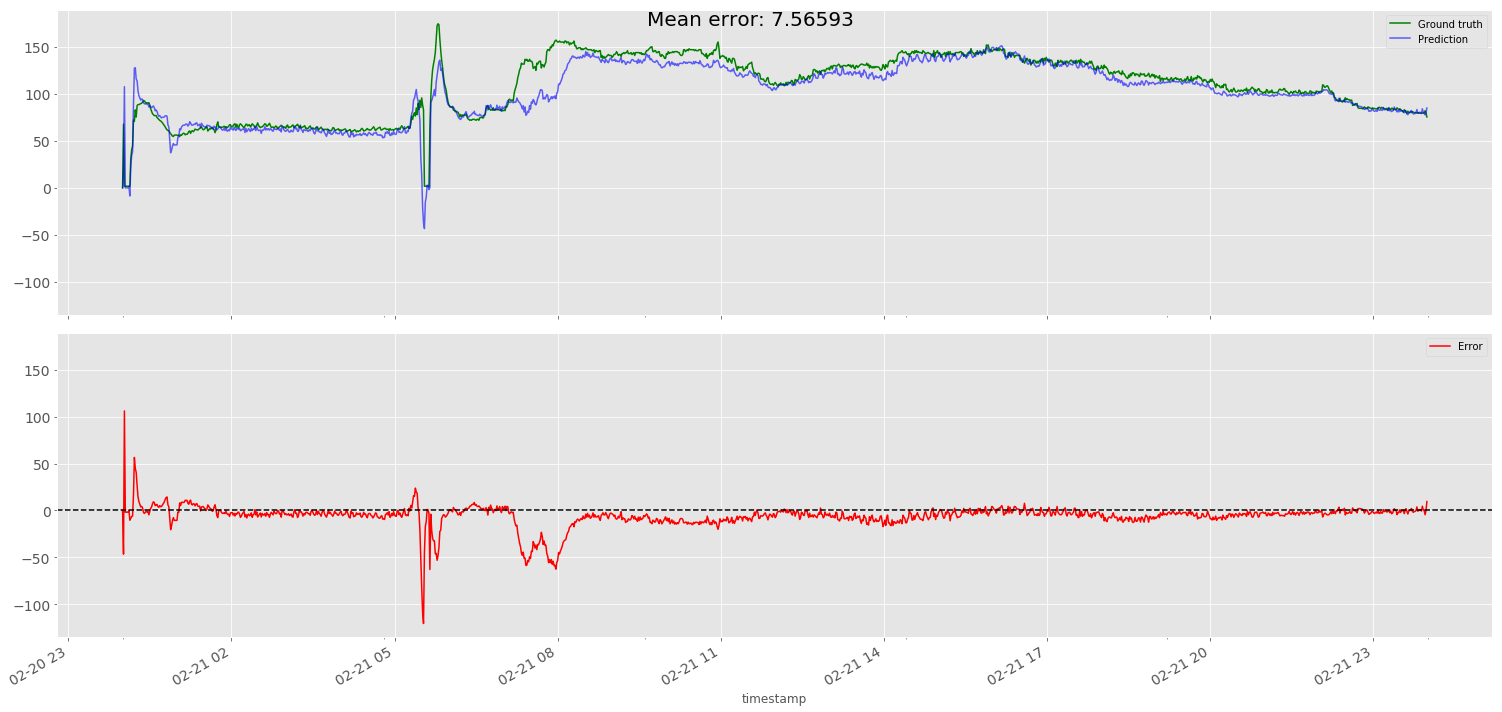

In [429]:
y1_pred, _ = gpr1.predict(d2_2006.values)
y2_pred, _ = gpr2.predict(d1_2006.values)
y3_pred, _ = gpr1.predict(d3_2006.values)

plot_model_error(y1_days_2006[1][1], y1_pred)
plot_model_error(y1_days_2006[0][1], y2_pred)
plot_model_error(y1_days_2006[20][1], y3_pred)

## Test models in different days in *different* year

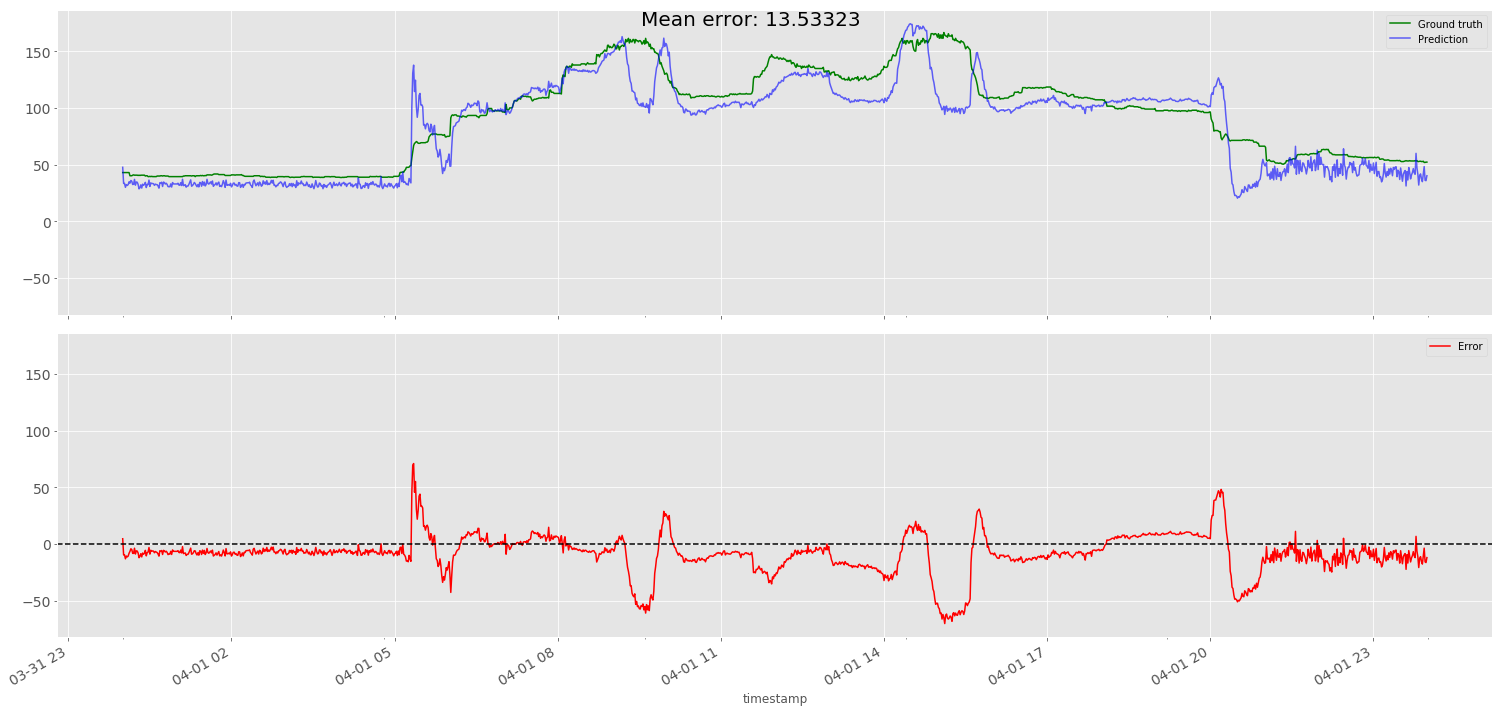

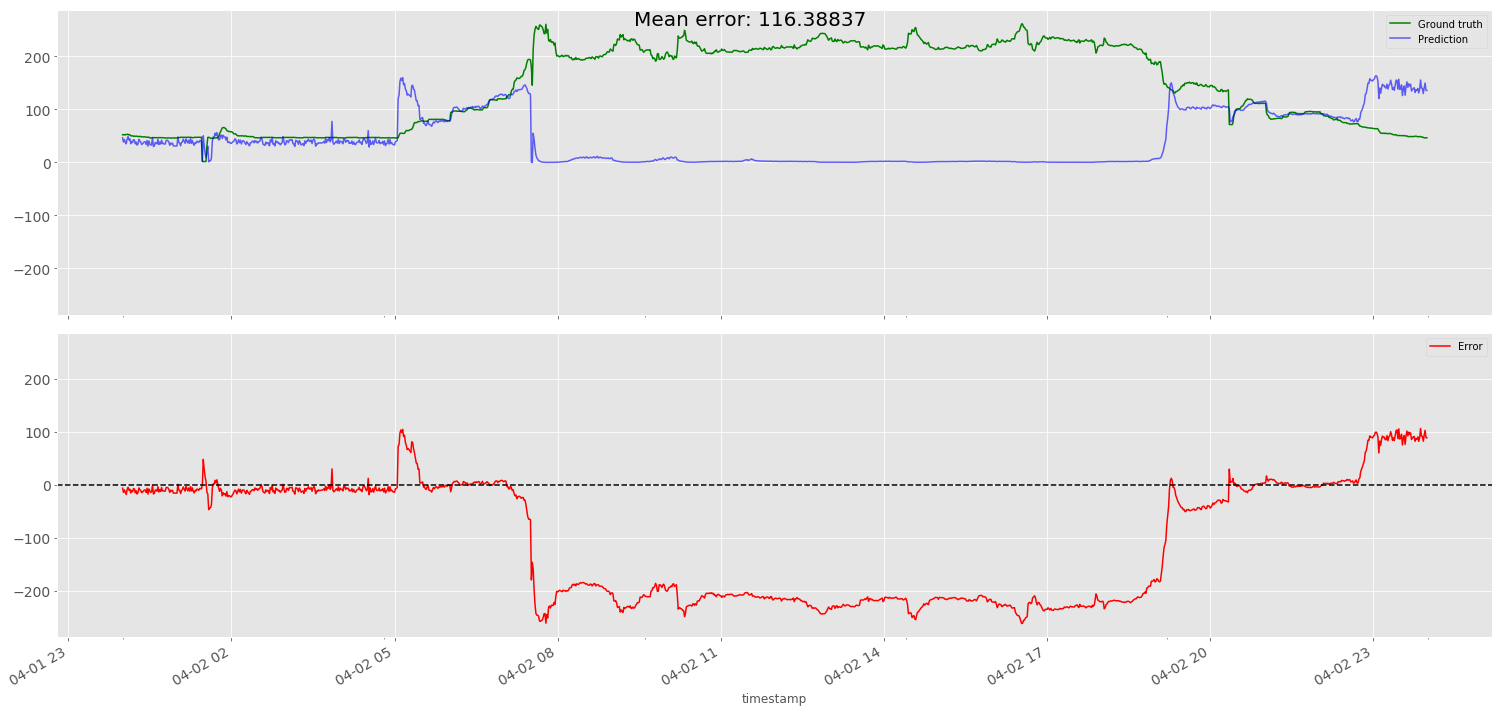

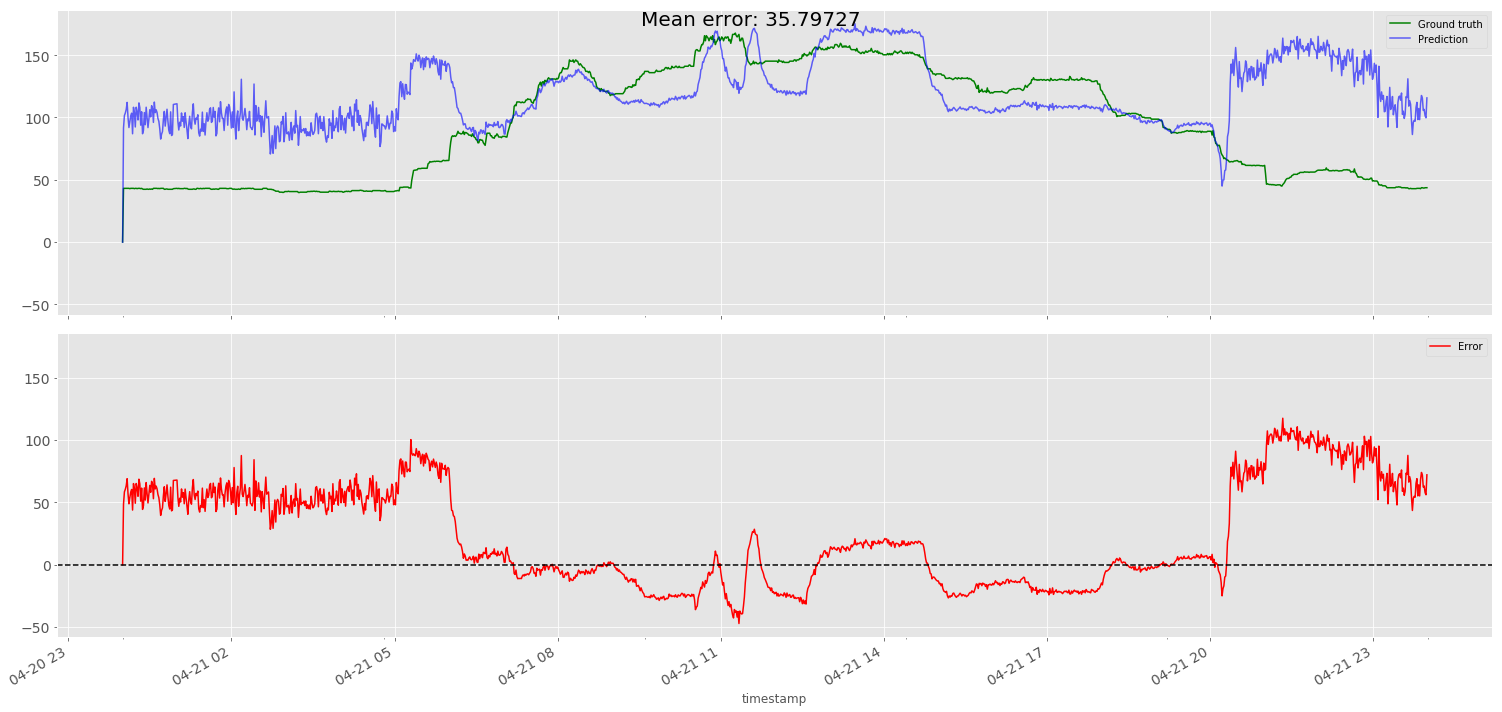

In [430]:
# Trained using 2016 first day data test on 2018 data

y1_pred, _ = gpr1.predict(d1_2008.values)
y2_pred, _ = gpr1.predict(d2_2008.values)
y3_pred, _ = gpr1.predict(d3_2008.values)

plot_model_error(y2_days_2008[0][1], y1_pred)
plot_model_error(y2_days_2008[1][1], y2_pred)
plot_model_error(y2_days_2008[20][1], y3_pred)

---

## Compare models

Test if two GP models are "same" given the data (x1, x2) where x1, x2 are data used to train the two GPs respectively.

This currently does **not** work.

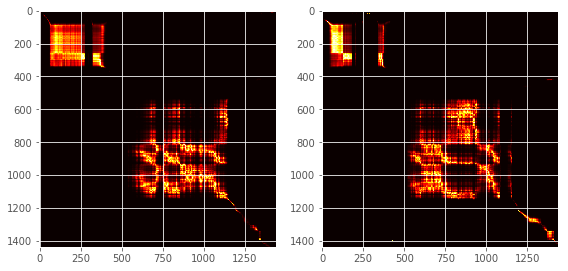

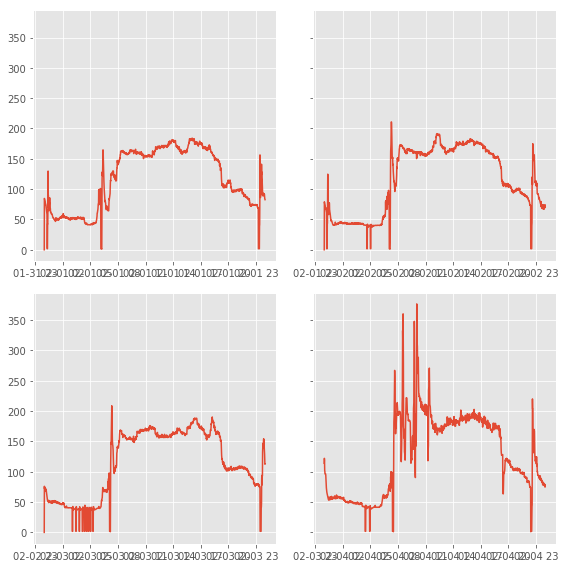

In [191]:
dim = d1_2006.shape[1]

k_matern32 = Matern32(input_dim=dim, lengthscale=12) #, variance=1)
k_matern52 = Matern52(input_dim=dim, lengthscale=12) #, variance=1)

K12 = k_matern32.K(d1_2006.values, d2_2006.values)
K13 = k_matern32.K(d1_2006.values, d3_2006.values)
K23 = k_matern32.K(d2_2006.values, d3_2006.values)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(K12, cmap=plt.cm.hot)
axes[1].imshow(K13, cmap=plt.cm.hot)
fig.tight_layout()

fig, axes = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(8, 8))

start = 0
for (ax, d) in zip(axes.ravel(), y1_days_2006[start:]):
    ax.plot(d[1])

fig.tight_layout()

In [230]:
X1 = d1_2006.values
X2 = d2_2006.values

X_test = np.vstack((X1, X2))
mu1, _ = gpr1.predict(X_test)
mu2, _ = gpr3.predict(X_test)

dmu = (mu1 - mu2).reshape(-1, 1)

# Check how to compute the posterior covariance
K1 = gpr1.posterior_covariance_between_points(X_test, X_test)
K2 = gpr2.posterior_covariance_between_points(X_test, X_test)
K = np.linalg.inv(K1 + K2)

test_statistic = dmu.T.dot(K).dot(dmu)
test_statistic

array([[15905.42911835]])

In [222]:
X1.shape, X2.shape, K1.shape, K2.shape

((81623, 6), (53147, 6), (2876, 2876), (2876, 2876))

In [240]:
K1star = gpr1.kern.K(X1, X_test)
K11 = gpr1.kern.K(X1, X1)

K1 = gpr1.kern.K(X_test, X_test) - K1star.T.dot( np.linalg.inv(K11 + np.eye(len(X1))) ).dot(K1star)

K2star = gpr2.kern.K(X2, X_test)
K22 = gpr2.kern.K(X2, X2)
K2 = gpr2.kern.K(X_test, X_test) - K2star.T.dot( np.linalg.inv(K22 + np.eye(len(X2))) ).dot(K2star)

K = K1 + K2

K1.shape, K2.shape

((2876, 2876), (2876, 2876))

In [244]:
dmu = mu1 - mu2

test_statistic = dmu.T.dot(K).dot(dmu)
test_statistic

array([[119393.97783483]])

In [245]:
np.linalg.cond(K1 + K2)

352930726441.30457

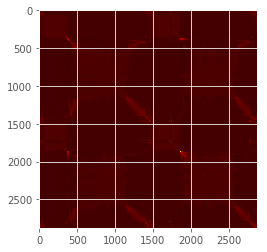

In [242]:
plt.imshow(K, cmap=plt.cm.hot)